# 0. Imports and Load Dataset

In [130]:
try:
    import dynamax
    import chex
    import flax
    from bayes_opt import BayesianOptimization
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    print('installing chex')
    %pip install chex
    print('installing flax')
    %pip install flax
    print('installing bayesopt')
    %pip install bayesian-optimization==1.4.1
    import dynamax
    import chex
    import flax
    from bayes_opt import BayesianOptimization

ImportError: cannot import name 'just_fix_windows_console' from 'colorama' (/usr/lib/python3/dist-packages/colorama/__init__.py)

In [72]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
import flax.linen as nn
from jax.flatten_util import ravel_pytree

from dynamax.utils.datasets import load_1d_synthetic_dataset
from dynamax.rebayes.ekf import RebayesEKF
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM

In [119]:
(X_train, y_train), (X_test, y_test) = load_1d_synthetic_dataset(n_train=200, n_test=400)
x_grid = jnp.linspace(-0.5, 1.0, 1000)

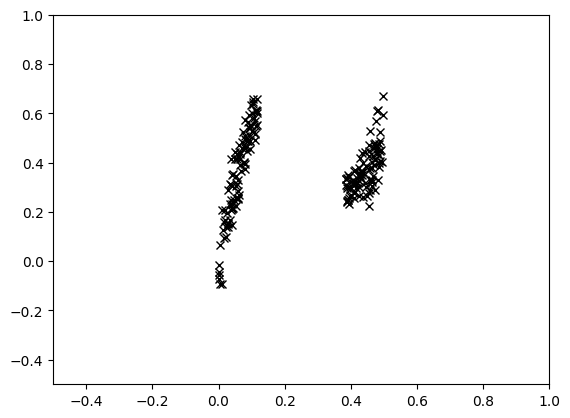

In [122]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, 'kx', label='data')
ax.set_xlim(-0.5, 1.0)
ax.set_ylim(-0.5, 1.0);

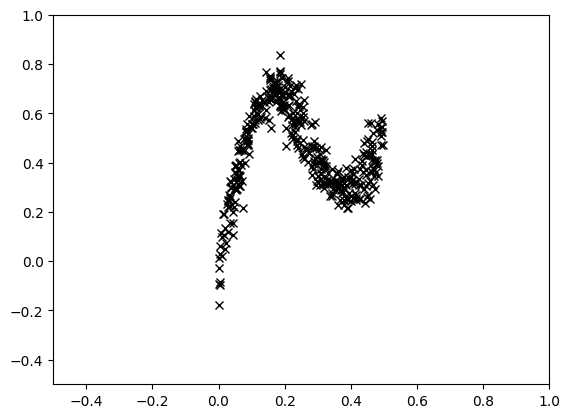

In [124]:
fig, ax = plt.subplots()
ax.plot(X_test, y_test, 'kx', label='data')
ax.set_xlim(-0.5, 1.0)
ax.set_ylim(-0.5, 1.0);

# 1. Posterior Predictive Computation

In [104]:
def linearized_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = F @ post_cov @ F.T + obs_noise

    return pred_mean, pred_cov


# 2. EKF Models

In [105]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.tanh(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

In [106]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [50,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(151,)


In [107]:
# Define the L2 loss
loss_fn = lambda w, x, y: (apply_fn(w, x) - y)**2

In [108]:
def mean_cov_callback(bel, t, x, y):
    return bel.mean, bel.cov

def run_ekf(X, Y, ekf_params, type='fcekf', callback=mean_cov_callback):
    estimator = RebayesEKF(ekf_params, method = type)
    _, filtered_means = estimator.scan(X, Y, callback=callback)

    return filtered_means

In [110]:
state_dim = flat_params.size
obs_noise = 1e-5
ekf_params = ParamsGGSSM(
    initial_mean=flat_params,
    initial_covariance=jnp.eye(state_dim),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim) * 0,
    emission_mean_function = lambda w, x: apply_fn(w, x),
    emission_cov_function = lambda w, x: jnp.array([obs_noise])
)


In [111]:
# Train FC-EKF
fcekf_post = run_ekf(X_train, y_train, ekf_params, type='fcekf')
fcekf_means, fcekf_covs = fcekf_post[0], fcekf_post[1]
fcekf_mean, fcekf_cov = fcekf_means[-1], fcekf_covs[-1]

In [112]:
def linearized_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = F @ post_cov @ F.T + obs_noise

    return pred_mean, pred_cov


In [113]:
pred_means, pred_covs = vmap(linearized_posterior_predictive_moments, (None, 0, None, None, None))(apply_fn, X_train, fcekf_mean, fcekf_cov, obs_noise)
pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

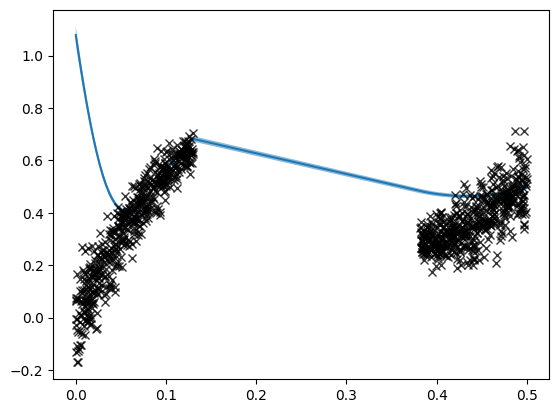

In [116]:
fig, ax = plt.subplots()
ax.plot(X_train, pred_means, label='mean');
ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8)
ax.fill_between(X_train.squeeze(), pred_means - 2 * jnp.sqrt(pred_covs), pred_means + 2 * jnp.sqrt(pred_covs), alpha=0.5, label='1 std');

In [39]:
pred_covs

DeviceArray([[[9.314922  ]],

             [[9.211714  ]],

             [[9.109129  ]],

             [[9.007168  ]],

             [[8.905829  ]],

             [[8.805114  ]],

             [[8.705022  ]],

             [[8.605555  ]],

             [[8.506709  ]],

             [[8.408487  ]],

             [[8.31089   ]],

             [[8.213916  ]],

             [[8.117564  ]],

             [[8.021836  ]],

             [[7.926733  ]],

             [[7.8322525 ]],

             [[7.7383943 ]],

             [[7.645161  ]],

             [[7.5525503 ]],

             [[7.4605618 ]],

             [[7.3691993 ]],

             [[7.27846   ]],

             [[7.1883416 ]],

             [[7.098849  ]],

             [[7.0099792 ]],

             [[6.921732  ]],

             [[6.834109  ]],

             [[6.7471094 ]],

             [[6.6607327 ]],

             [[6.5749807 ]],

             [[6.489852  ]],

             [[6.405345  ]],

             [[6.321462  ]],

          